# Feature Extraction

To solve "Buy or not" classification task we need to build following features describing a given session:

**P1**: Total number of clicks during the session.

**P2**: Average number of clicks per item.

**P3**: Total duration of the session.

**P4**: Maximal duration between two clicks.

**P5**: Average duration between clicks in the session.

**P6**: Maximal number of times the session has clicked on the same item.

**P7**: Average of items’ buying probabilities in the session.

**P8**: Maximum of items’ buying probabilities in the session.

**P9**: Probability of buying at least one item in the session.

**P10**: Maximal number of consecutive clicks on any item in the session.

**P11**: Maximal duration between two consecutive clicks on any item in the session.

Feature P9 is excluded. 

In [1]:
import numpy as np
from collections import Counter

In [2]:
import datetime
from dateutil.parser import parse
import time
#time_obj = parse(time_str)

In [3]:
with open('./clicks.txt') as f:
    clicks = [ l for l in f.read().split('\n') if len(l) > 0 ]

In [4]:
with open('./yoochoose-buys.dat') as f:
    buys = [ l for l in f.read().split('\n') if len(l) > 0 ]

Parsing the clicks' data:

In [5]:
sessions = np.zeros(dtype=int, shape = (len(clicks)))
times = np.zeros(dtype='double', shape = (len(clicks)))
items = np.zeros(dtype='int64', shape = (len(clicks)))

for i in xrange(len(clicks)):
    string = clicks[i]
    string = string.split(',')
    
    session = int(string[0])
    t = parse(string[1])
    t = time.mktime(t.timetuple())
    item = int(string[2])
    
    sessions[i] = session 
    times[i] = t
    items[i] = item

In [6]:
np.save('./sessions', sessions)
np.save('./times', times)
np.save('./items', items)

Parsing the buys' data:

In [7]:
b_sessions = np.zeros(dtype=int, shape = len(buys))
b_times = np.zeros(dtype='double', shape = len(buys))
b_items = np.zeros(dtype='int64', shape = len(buys))
counts = np.zeros(dtype=int, shape=len(buys))

for i in xrange(len(buys)):
    session_id, timestamp, item, price, count = buys[i].split(',')
    b_sessions[i] = int(session_id)
    b_times[i] = time.mktime(parse(timestamp).timetuple())
    b_items[i] = long(item)
    counts[i] = int(count)

Sorting data by session ID:

In [8]:
index = np.argsort(sessions)
sessions = sessions[index]
times = times[index]
items = items[index]

index = np.argsort(b_sessions)
b_sessions = b_sessions[index]
b_times = b_times[index]
b_items = b_items[index]
counts = counts[index]

del index

In [9]:
import collections

from collections import defaultdict

Computes intermediate dictionaries:
- session ID to session's items;
- session ID to session's times of clicks;
- session ID to session's start time (minimum of session times).

In [10]:
def session_info(sessions, times, items):
    
    from collections import defaultdict
    
    session_times = defaultdict(lambda: list())
    session_items = defaultdict(lambda: list())
    
    for i in xrange(sessions.shape[0]):
        session_times[sessions[i]].append(times[i])
        session_items[sessions[i]].append(items[i])
    
    session_start_times = dict()
    for session in session_times:
        ts = np.array(session_times[session])
        its = np.array(session_items[session])
        
        indx = np.argsort(ts)
        ts = ts[indx]
        its = its[indx]
        
        session_times[session] = ts
        session_start_times[session] = np.min(ts)
        assert session_times[session].shape[0] > 0
        
        session_items[session] = its
        assert session_items[session].shape[0] > 0
    
    return session_times, session_start_times, session_items

Computes reverse dictionaries:
- item ID to list of sessions in which given item was clicked;
- item ID to list of times when corresponding sessions have started.

In [11]:
def item_sessions(items, sessions, sessions_start_time):
    
    from collections import defaultdict
    
    item_sessions = defaultdict(lambda: list())
    item_sessions_start = dict()
    
    for i in xrange(items.shape[0]):
        item_sessions[items[i]].append(sessions[i])  
    
    # delete duplicates and sort by times
    
    item_sessions_clicked = dict()
    
    for item in item_sessions:
        ss = np.array(list(set(item_sessions[item])))
        session_starts = np.array([ sessions_start_time[s] for s in ss ])
        
        idx = np.argsort(session_starts)
        item_sessions_clicked[item] = ss[idx]
        item_sessions_start[item] = session_starts[idx] 
        
        
    return item_sessions_clicked, item_sessions_start

### Baseline probabilities
Here we compute the features which are related to baseline probabilities.

In [12]:
def baseline_probabilities(clicked_items, click_times, bought_items, N=25):
    probs = dict()
    probs_times = dict()
    
    for item in clicked_items:
        times = click_times[item]
        S = clicked_items[item]
        P = bought_items[item] if item in bought_items else np.array([])

        buy_or_not = np.zeros(shape=len(S), dtype = "int8")

        session_index = defaultdict(lambda: list())

        for i in xrange(len(S)):
            session_index[S[i]] = i  
        
        if S.shape[0] <= N:
            prob = P.shape[0] / S.shape[0]
            probs[item] = np.array([prob])
            probs_times[item] = np.array([np.max(times)])
        else:
            ns = np.array([ session_index[p] for p in P ])
            if ns.shape[0] > 0:
                buy_or_not[ns] = 1
            cum_buy_or_not = np.cumsum(buy_or_not)
        
            number_of_buys = cum_buy_or_not[N:] - cum_buy_or_not[:-N]
            prob = number_of_buys / float(N)
            probs[item] = np.array(prob)
            probs_times[item] = times[N:]
            
    return probs, probs_times

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def get_probabilities_info(session_items, session_times, item_probs, probs_times):
 
    session_av_probability = dict() 
    session_max_probability = dict()
    max_probability = dict()
    
    for session in session_items:
                
        items = session_items[session]
        n_items = items.shape[0]
        
        one_item_one_probability = np.zeros(shape=items.shape[0], dtype = float)
        
        for i in xrange(items.shape[0]):
            
            item = items[i]
            t = session_times[session][i]            
            
            all_item_times = probs_times[item]
            
            j = np.searchsorted(all_item_times, t, side='left')
            
            if j != 0:
                one_item_one_probability[i] = item_probs[item][j-1]
            else:
                one_item_one_probability[i] = 0
            
        max_probability[session] = np.max(one_item_one_probability)
                        
        session_av_probability[session] = np.mean(one_item_one_probability)
        
        
    return session_av_probability, max_probability

### Consecutive clicks info
Defining functions to extract consecutive clicks related features:

In [15]:
def max_consecutive(seq):
    if len(seq) == 0:
        return 0

    current = seq[0]
    current_sc = 1
    max_sc = 1

    for i in range(1, len(seq)):
        if current == seq[i]:
            current_sc += 1
        else:
            current = seq[i]
            current_sc = 1

        if current_sc > max_sc:
            max_sc = current_sc   
            
    if current_sc > max_sc:
        max_sc = current_sc   
    
    return max_sc

def max_cons_duration(seq, ts):
    if seq.shape[0] < 2:
        return 0.0
    else:
        return np.max((seq[1:] - seq[:-1]) * (ts[1:] - ts[:-1]))

In [16]:
def get_consecutive_clicks_stats(session_items, session_times):
    
    maximal_duration = dict()
    maximal_cons_clicks = dict()
    
    for session in session_items:
        seq = session_items[session]
        timestamps = session_times[session]
        
        maximal_duration[session] = max_cons_duration(seq, timestamps)
        
        maximal_cons_clicks[session] = max_consecutive(seq)


    return maximal_cons_clicks, maximal_duration
        

### The rest
Defining the function which extracts the rest of the features and computing intermediate characteristics.

In [17]:
def get_session_stats(times, items):
    
    from collections import Counter
    
    index = np.argsort(times)
    times = times[index]
    items = items[index]

    # P1
    total_number_of_clicks = times.shape[0]
    
    clicks_per_item = Counter(items).values()
    
    # P2
    average_clicks_per_item = np.mean(clicks_per_item)
    
    # P6
    maximal_clicks_on_item = np.max(clicks_per_item)
    
    # P3
    total_duration_of_session = times[-1] - times[0]
    
    delta_t = times[1:] - times[:-1]
    
    if delta_t.shape[0] > 0:
        # P4
        maximal_duration_between_clicks = np.max(delta_t)
    
        # P5
        average_duration_between_clicks = np.mean(delta_t)
    else:
        maximal_duration_between_clicks = 0.0
        average_duration_between_clicks = 0.0
    
    return total_number_of_clicks, average_clicks_per_item, \
        total_duration_of_session, maximal_duration_between_clicks, \
        average_duration_between_clicks, maximal_clicks_on_item

In [18]:
session_times, sessions_start_time, session_items = session_info(sessions, times, items)
    
clicked_items, clicks_times = item_sessions(items, sessions, sessions_start_time)
bought_items, _ = item_sessions(b_items, b_sessions, sessions_start_time)
item_probs, probs_times = baseline_probabilities(clicked_items, clicks_times, bought_items, N=25)

In [19]:
b_session_times, b_session_start_time, b_session_items = session_info(b_sessions, b_times, b_items)

### Features extraction itself
Now we have the whole set of functions needed to build the table of features.
The function below returns such table represented as numpy-array.

In [20]:
### 1. def get_features(sessions, times, items, b_sessions, b_times, b_items):
    
    
    P7, P8 = get_probabilities_info(session_items, session_times, item_probs, probs_times)
    
    P10, P11 = get_consecutive_clicks_stats(session_items, session_times)
    
    ended_with_buy = set(b_sessions.tolist())
    target = np.zeros(shape=len(session_times.keys()))
    dataset = np.ndarray(shape=(len(session_times.keys()), 10))
    
    session_ids = np.ndarray(shape=len(session_times.keys()), dtype='int32')
    
    for session_n, session_id in enumerate(session_times.keys()):
        
        session_ids[session_n] = session_id
        
        timestamps = session_times[session_id]
        its = session_items[session_id]
        
        P1, P2, P3, P4, P5, P6 = get_session_stats(timestamps, its)
        
        dataset[session_n, 0] = P1
        dataset[session_n, 1] = P2
        dataset[session_n, 2] = P3
        dataset[session_n, 3] = P4
        dataset[session_n, 4] = P5
        dataset[session_n, 5] = P6
        dataset[session_n, 6] = P7[session_id]
        dataset[session_n, 7] = P8[session_id]
        dataset[session_n, 8] = P10[session_id]
        dataset[session_n, 9] = P11[session_id]
        
        if session_id in ended_with_buy:
            target[session_n] = 1
    
    return dataset, target, session_ids

In [21]:
dataset, target, session_ids = get_features(sessions, times, items, b_sessions, b_times, b_items)

In [22]:
np.save('./dataset', dataset)
np.save('./target', target)
np.save('./session_ids', session_ids)

### F-features

We also need to extract the following session-to-item features:

F1: Indicator of the item being the first item clicked.

F2: Indicator of the item being the last item clicked.

F3: Number of times the item was clicked in the session.

F4: Time spent on the item during the session.

F5: Baseline probability of the item being bought.

F6: Number of consecutive clicks on the item.

F7: Maximal duration between consecutive clicks on item.

In [23]:
def get_consecutive_clicks_info(seq, times):
    
    deltas = times[1:] - times[:-1]
        
    item_max_sc = defaultdict(lambda: 1)
    item_max_duration_between_sc = dict()
    
    for item in seq:
        item_max_duration_between_sc[item] = 0.0
    
    
    if len(seq) == 0:
        return item_max_sc, item_max_duration_between_sc

    current = seq[0]
    current_sc = 1
    
    for i in range(1, len(seq)):
                
        if current == seq[i]:
            current_sc += 1
            if item_max_duration_between_sc[seq[i]] < deltas[i-1]:
                item_max_duration_between_sc[seq[i]] = deltas[i-1]
        else:
            if current_sc > item_max_sc[seq[i-1]]:
                item_max_sc[seq[i-1]] = current_sc 
            current = seq[i]
            current_sc = 1
    
    i = len(seq)        
    if current_sc > item_max_sc[seq[i-1]]:
        item_max_sc[seq[i-1]] = current_sc 

    return item_max_sc, item_max_duration_between_sc 

In [24]:
def get_f_features(session, session_times, session_items, probs_times):

    item_first_or_not = dict()
    item_last_or_not = dict()
    item_number_of_clicks = dict()
    item_total_time_spent_on_item = defaultdict(lambda: 0.0)
    item_probability = dict()
    item_number_of_cons_clicks = dict()
    item_max_duration_between_cons_clicks = dict()
    
    items = session_items[session]
    times = session_times[session]
     
    delta = times[1:] - times[:-1]
    if items.shape[0] > 1:
        av_delta = np.mean(delta)
    else:
        av_delta = 0.0
    
    for i in xrange(items.shape[0]):
        item_first_or_not[items[i]] = 0
        item_last_or_not[items[i]] = 0        
        
        if i == items.shape[0] - 1:
            item_total_time_spent_on_item[items[i]] += av_delta
        else:
            item_total_time_spent_on_item[items[i]] += delta[i]
        
        # probability search starts
        t = session_times[session][i]            
        all_item_times = probs_times[items[i]]
        j = np.searchsorted(all_item_times, t, side='left')
        if j != 0:
            item_probability[items[i]] = item_probs[items[i]][j-1]
        else:
            item_probability[items[i]] = 0
        # probability search ends
        
    item_first_or_not[items[0]] = 1
    item_last_or_not[items[-1]] = 1
    item_number_of_clicks = Counter(items)
    
    item_max_sc, item_max_duration_between_sc  = get_consecutive_clicks_info(session_items[session], 
                                                                             session_times[session])
    
    return item_first_or_not, item_last_or_not, item_number_of_clicks, \
            item_total_time_spent_on_item, item_probability, item_max_sc, \
            item_max_duration_between_sc 
    

In [25]:
def get_table_of_f_features():
    
    shape_of_dataset = 0
    for session in session_items:
        items = session_items[session]
        shape_of_dataset += len(set(items.tolist()))
    
    f_dataset = np.zeros(shape=(shape_of_dataset, 7), dtype='double')
    session_ids = np.zeros(shape=shape_of_dataset, dtype = 'int32')
    item_ids = np.zeros(shape=shape_of_dataset, dtype = 'int32')
    f_target = np.zeros(shape=shape_of_dataset, dtype='int') 
    
    n = 0
    
    for session in session_items:
        
        if session in b_session_items:
            buy_items = set(b_session_items[session].tolist())
        else:
            buy_items = set()
            
        items = session_items[session]
        times = session_times[session]
        F1, F2, F3, F4, F5, F6, F7 = get_f_features(session, session_times, session_items, probs_times)
        for item in set(items.tolist()):
            
            f_target[n] = 1 if item in buy_items else 0
            
            session_ids[n] = session
            item_ids[n] = item
            f_dataset[n,0] = F1[item]
            f_dataset[n,1] = F2[item]
            f_dataset[n,2] = F3[item]
            f_dataset[n,3] = F4[item]
            f_dataset[n,4] = F5[item]
            f_dataset[n,5] = F6[item]
            f_dataset[n,6] = F7[item]
            n+=1
            
    return f_dataset, f_target, session_ids, item_ids

In [27]:
f_dataset, f_target, session_ids, item_ids = get_table_of_f_features()

In [28]:
np.save('./f_dataset', f_dataset)
np.save('./f_target', f_target)
np.save('./f_item_ids', item_ids)
np.save('./f_session_ids', session_ids)

### Simple test to check correctness of extracted features

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth = 5)

In [30]:
rf.fit(f_dataset, f_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

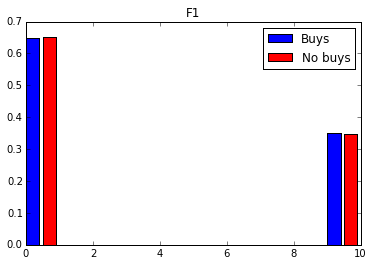

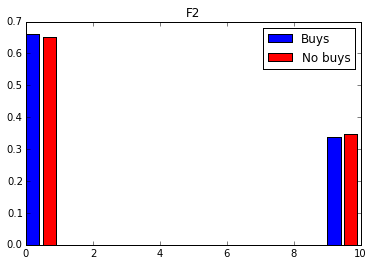

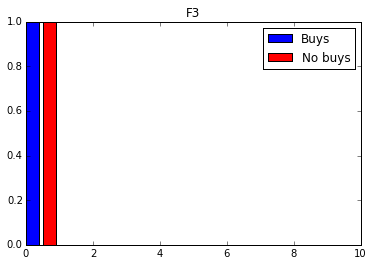

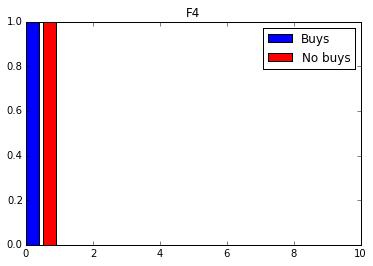

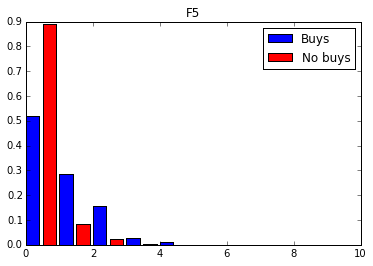

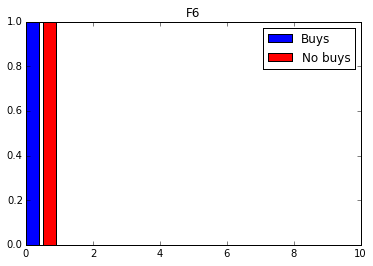

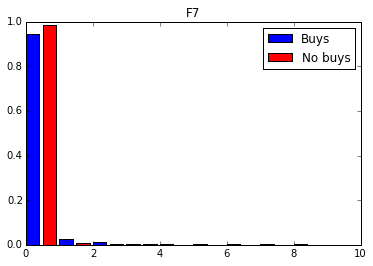

In [31]:
bindx = f_target == 1
nbindx = f_target == 0

for i in range(f_dataset.shape[1]):
    plt.figure()
    plt.title("F%d" % (i + 1))
    amin, amax = np.min(f_dataset[:, i]), np.max(f_dataset[:, i])
    
    bhist, _ = np.histogram(f_dataset[bindx, i], bins=10, range=(amin, amax))
    nbhist, _ = np.histogram(f_dataset[nbindx, i], bins=10, range=(amin, amax))
    
    bhist = bhist / float(np.sum(bhist))
    nbhist = nbhist / float(np.sum(nbhist))
    
    plt.bar(np.arange(10), bhist, width = 0.4, color = "blue", label='Buys')
    plt.bar(np.arange(10) + 0.5, nbhist, width = 0.4, color='red', label='No buys')
    plt.legend(loc=('upper right'))
    plt.show()

In [32]:
for i, imp in enumerate(rf.feature_importances_):
    print "F%d" % (i + 1), imp

F1 0.0180084358975
F2 0.0128051804778
F3 0.178447169744
F4 0.0549230036554
F5 0.643836820162
F6 0.00684876822367
F7 0.0851306218392


As one can see, all of the features have non-zero importance, thus feature extraction is most probably correct. 